<a href="https://colab.research.google.com/github/gargi411/Optimized-weed-detection-using-bio-inspired-genetic-algorithm-and-deep-CNN/blob/main/Weed_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: install + imports
!pip -q install tensorflow-datasets

import os, math, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import classification_report, confusion_matrix
import itertools
print("TF:", tf.__version__)


TF: 2.19.0


In [ ]:
# Cell 2: load dataset (will download ~5 GB)
ds, ds_info = tfds.load("deep_weeds", split=['train'], with_info=True, as_supervised=True)
# deep_weeds is delivered as a single 'train' split; we'll create train/val/test ourselves
dataset = ds[0]
print(ds_info)
CLASS_NAMES = ds_info.features['label'].names
print("Classes:", CLASS_NAMES)


tfds.core.DatasetInfo(
    name='deep_weeds',
    full_name='deep_weeds/3.0.0',
    description="""
    The DeepWeeds dataset consists of 17,509 images capturing eight different weed species native to Australia in situ with neighbouring flora.The selected weed species are local to pastoral grasslands across the state of Queensland.The images were collected from weed infestations at the following sites across Queensland: "Black River", "Charters Towers",  "Cluden", "Douglas", "Hervey Range", "Kelso", "McKinlay" and "Paluma".
    """,
    homepage='https://github.com/AlexOlsen/DeepWeeds',
    data_dir='/root/tensorflow_datasets/deep_weeds/3.0.0',
    file_format=tfrecord,
    download_size=469.32 MiB,
    dataset_size=469.99 MiB,
    features=FeaturesDict({
        'image': Image(shape=(256, 256, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=9),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False

In [ ]:
# Cell 3: preprocessing + split
IMG_SIZE = 160        # reduce image size to save RAM (160 or 128)
BATCH = 8             # reduce batch size (8 or 16) — biggest RAM win
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# map but do NOT call .cache(); keep pipeline streaming
dataset = dataset.map(preprocess, num_parallel_calls=AUTOTUNE)

# get dataset size from ds_info (avoid iterating through dataset)
ds_size = ds_info.splits['train'].num_examples
print("Total images (from ds_info):", ds_size)

# shuffle buffer can be smaller than full dataset to save RAM
SHUFFLE_BUFFER = 2000

# shuffle then split 80/10/10
dataset = dataset.shuffle(SHUFFLE_BUFFER, seed=SEED, reshuffle_each_iteration=False)

train_size = int(0.8 * ds_size)
val_size   = int(0.1 * ds_size)
test_size  = ds_size - train_size - val_size
print("Split sizes:", train_size, val_size, test_size)

# Take / skip, then batch. Use prefetch(1) to limit memory spike.
train_ds = dataset.take(train_size).batch(BATCH).prefetch(1)
rest = dataset.skip(train_size)
val_ds = rest.take(val_size).batch(BATCH).prefetch(1)
test_ds = rest.skip(val_size).batch(BATCH).prefetch(1)



Total images (from ds_info): 17509
Split sizes: 14007 1750 1752


In [ ]:
# Cell 4: model (transfer learning)
base = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE,IMG_SIZE,3),
                                         include_top=False, weights='imagenet')
base.trainable = False  # freeze base for speed

inputs = tf.keras.Input(shape=(IMG_SIZE,IMG_SIZE,3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │        11,529 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,269,513 (8.66 MB)

 Trainable params: 11,529 (45.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Cell 5: train (use modest epochs now; enlarge if time allows)
EPOCHS = 10
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_deepweeds_mobilenet.h5", save_best_only=True, monitor='val_sparse_categorical_accuracy', mode='max'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=6, restore_best_weights=True, mode='max', verbose=1)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)


Epoch 1/10
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 1.8200 - sparse_categorical_accuracy: 0.4937

1751/1751 ━━━━━━━━━━━━━━━━━━━━ 379s 206ms/step - loss: 1.8199 - sparse_categorical_accuracy: 0.4937 - val_loss: 1.6644 - val_sparse_categorical_accuracy: 0.5286 - learning_rate: 1.0000e-04
Epoch 2/10
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 326s 185ms/step - loss: 1.7604 - sparse_categorical_accuracy: 0.5176 - val_loss: 1.6487 - val_sparse_categorical_accuracy: 0.5286 - learning_rate: 1.0000e-04
Epoch 3/10
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 328s 186ms/step - loss: 1.7269 - sparse_categorical_accuracy: 0.5185 - val_loss: 1.6387 - val_sparse_categorical_accuracy: 0.5286 - learning_rate: 1.0000e-04
Epoch 4/10
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 326s 185ms/step - loss: 1.7073 - sparse_categorical_accuracy: 0.5191 - val_loss: 1.6320 - val_sparse_categorical_accuracy: 0.5286 - learning_rate: 1.0000e-04
Epoch 5/10
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 327s 184ms/step - loss: 1.6882 - sparse_categorical_accuracy: 0.5190 - val_loss: 1.6238 - val_sparse_categorical_accuracy: 0.5286 - learning_rate: 1.0000e-04
Epoch 6/10


1751/1751 ━━━━━━━━━━━━━━━━━━━━ 326s 185ms/step - loss: 1.6808 - sparse_categorical_accuracy: 0.5194 - val_loss: 1.6193 - val_sparse_categorical_accuracy: 0.5291 - learning_rate: 1.0000e-04
Epoch 7/10
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 1.6702 - sparse_categorical_accuracy: 0.5194

1751/1751 ━━━━━━━━━━━━━━━━━━━━ 331s 188ms/step - loss: 1.6701 - sparse_categorical_accuracy: 0.5194 - val_loss: 1.6145 - val_sparse_categorical_accuracy: 0.5297 - learning_rate: 1.0000e-04
Epoch 8/10
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 324s 184ms/step - loss: 1.6636 - sparse_categorical_accuracy: 0.5181 - val_loss: 1.6101 - val_sparse_categorical_accuracy: 0.5297 - learning_rate: 1.0000e-04
Epoch 9/10
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 1.6544 - sparse_categorical_accuracy: 0.5197

1751/1751 ━━━━━━━━━━━━━━━━━━━━ 324s 184ms/step - loss: 1.6544 - sparse_categorical_accuracy: 0.5197 - val_loss: 1.6062 - val_sparse_categorical_accuracy: 0.5309 - learning_rate: 1.0000e-04
Epoch 10/10
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 1.6512 - sparse_categorical_accuracy: 0.5194

1751/1751 ━━━━━━━━━━━━━━━━━━━━ 338s 192ms/step - loss: 1.6512 - sparse_categorical_accuracy: 0.5194 - val_loss: 1.6040 - val_sparse_categorical_accuracy: 0.5314 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 10.


219/219 ━━━━━━━━━━━━━━━━━━━━ 49s 154ms/step - loss: 1.6352 - sparse_categorical_accuracy: 0.5143
Test acc: 0.5126
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

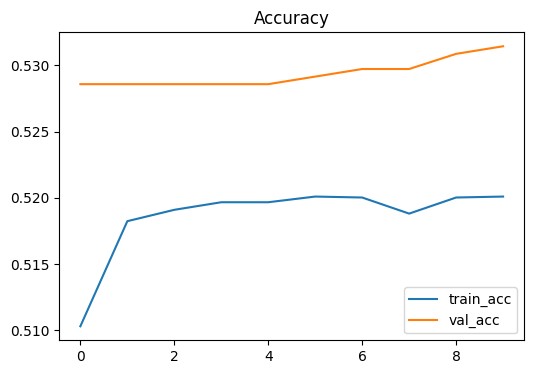

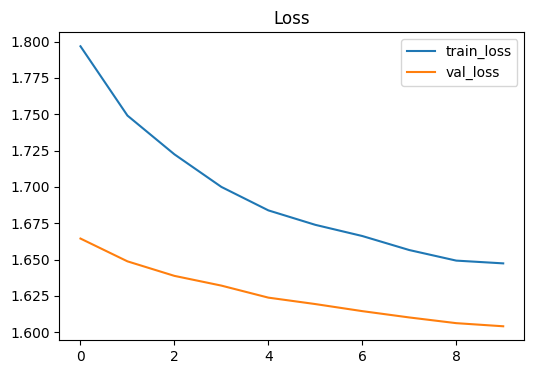

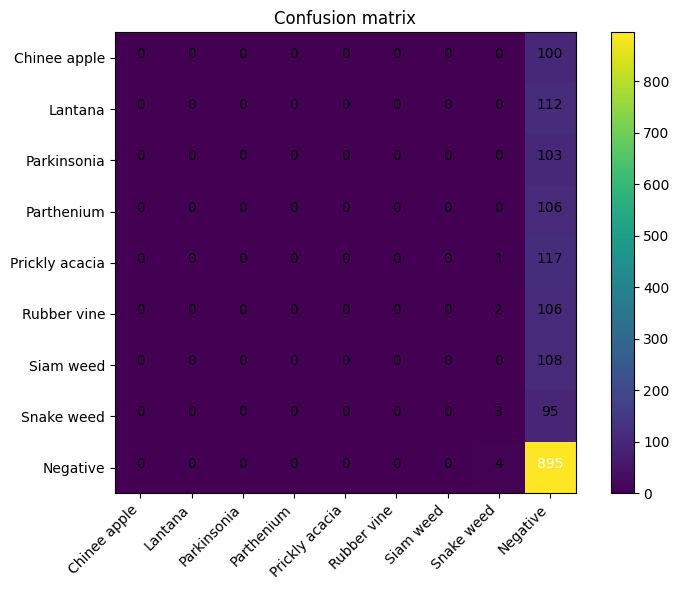

Saved artifact at 'deepweeds_mobilenet_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 9), dtype=tf.float32, name=None)
Captures:
  139590885276752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139590867600400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139590867600784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139590885263888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139590885276944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139590885277136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139590867601168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139590867602128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139590867600016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139590867600208: TensorSpec(shape=(), dtype=tf.resource, name=None

In [ ]:
# Cell 6: evaluate & plots
# Evaluate on test set
loss, acc = model.evaluate(test_ds)
print(f"Test acc: {acc:.4f}")

# Predictions for classification report / confusion matrix
y_true = []
y_pred = []
for batch_x, batch_y in test_ds:
    probs = model.predict(batch_x)
    preds = np.argmax(probs, axis=1)
    y_true.extend(batch_y.numpy().tolist())
    y_pred.extend(preds.tolist())

print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, zero_division=0))

cm = confusion_matrix(y_true, y_pred)

# plot history
plt.figure(figsize=(6,4))
plt.plot(history.history['sparse_categorical_accuracy'], label='train_acc')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy'); plt.savefig('accuracy.png'); plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss'); plt.savefig('loss.png'); plt.show()

# plot confusion
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest'); plt.title('Confusion matrix'); plt.colorbar()
tick_marks = np.arange(len(CLASS_NAMES))
plt.xticks(tick_marks, CLASS_NAMES, rotation=45, ha='right')
plt.yticks(tick_marks, CLASS_NAMES)
thresh = cm.max() / 2.
for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i,j], 'd'), ha='center', color='white' if cm[i,j]>thresh else 'black')
plt.tight_layout(); plt.savefig('confusion.png'); plt.show()

# Save final model (if you want the TF SavedModel)
model.save("deepweeds_mobilenet_savedmodel")
print("Saved model and plots.")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive
